In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
import itertools
from collections import Counter, defaultdict
import numpy as np
import scipy.stats, scipy.spatial, scipy.signal
import os
import json
from path import Path; Path.stem = Path.namebase
from natsort import natsorted
from tqdm import tqdm

from ppm3d import Cluster, align, AlignedData
from motifextraction import load_cns
from motifextraction.utils import get_norm_factors, FractionalCounter

In [2]:
data_path = Path("../data")
cluster_path = data_path / "clusters"
motif_path = data_path / "averaged"
motif_errors_path = data_path / "motif_errors"
errors_path = data_path / "errors"

In [3]:
cluster_cns = load_cns(cluster_path).astype(int)
NCLUSTERS = len(cluster_cns)
print(NCLUSTERS)
print(Counter(cluster_cns))

Loading cns...
9826
Counter({12: 2285, 13: 1980, 11: 1929, 10: 1441, 14: 1400, 15: 440, 9: 281, 16: 58, 8: 8, 17: 4})


In [4]:
motif_fns = natsorted(motif_path.glob("*.xyz"))
motif_fns = [f for f in motif_fns if not f.stem.startswith("ignore")]
#motif_fns = [motif_fns[-1]] + motif_fns[:-1]  # move the CN 9 motif to the beginning
#motif_fns = ["final_motifs/" + f for f in motif_fns]
#print(motif_fns)
NMOTIFS = len(motif_fns)
print(NMOTIFS)

#figure_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'i', 'l', 'm', 'n', 'o', 'p']
#for fn, l in zip(motif_fns, figure_labels):
#    print(l, fn)

128


In [5]:
motifs = [Cluster(filename=fn) for fn in motif_fns]

In [20]:
CN = 12
motifs_12 = [motif for motif in motifs if motif.CN == CN]
len(motifs_12)

27

In [21]:
# Load norm factors
with open(data_path / "norm_factors.json") as f:
    _norm_factors = json.load(f)
    L2_norm_factors = _norm_factors["L2"]
    L1_norm_factors = _norm_factors["L1"]
    Linf_norm_factors = _norm_factors["Linf"]
    angular_norm_factors = _norm_factors["angular"]

In [22]:
# Load motif errors
motif_errors = np.zeros((NMOTIFS, NCLUSTERS, 4))
motif_errors.fill(np.nan)
for i, fn in enumerate(motif_fns):
    stem = '_'.join(fn.namebase.split('_')[:])
    efn = motif_errors_path / (stem + '_errors.npy')
    motif_errors[i, :, :] = np.load(efn)

motif_errors[:, :, 0]
motif_errors[:, :, 0][np.where(motif_errors[:, :, 0] > L2_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 0][np.isinf(motif_errors[:, :, 0])] = np.nan
motif_errors[:, :, 0] /= L2_norm_factors['divide_by']

motif_errors[:, :, 1]
motif_errors[:, :, 1][np.where(motif_errors[:, :, 1] > L1_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 1][np.isinf(motif_errors[:, :, 1])] = np.nan
motif_errors[:, :, 1] /= L1_norm_factors['divide_by']

motif_errors[:, :, 2]
motif_errors[:, :, 2][np.where(motif_errors[:, :, 2] > Linf_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 2][np.isinf(motif_errors[:, :, 2])] = np.nan
motif_errors[:, :, 2] /= Linf_norm_factors['divide_by']

motif_errors[:, :, 3]
motif_errors[:, :, 3][np.where(motif_errors[:, :, 3] > angular_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 3][np.isinf(motif_errors[:, :, 3])] = np.nan
motif_errors[:, :, 3] /= angular_norm_factors['divide_by']

motif_errors = scipy.stats.gmean(motif_errors, axis=2)
print(motif_errors.shape)

(128, 9826)


In [23]:
motif_errors_12 = [motif_errors[i, :] for i, motif in enumerate(motifs) if motif.CN == CN]
len(motif_errors_12)

27

In [6]:
def smooth(y):
    wl = max(len(y) // 3, 11)
    if wl % 2 == 0:
        wl += 1
    return scipy.signal.savgol_filter(y, window_length=wl, polyorder=3)

In [7]:
def get_cdf(errors):
    h, bins = np.histogram(errors, bins=30)
    centers = (bins[:-1] + bins[1:]) / 2
    s = smooth(h)
    width = centers[1] - centers[0]
    #plt.bar(centers, h, align='center', width=width)
    #plt.plot(centers, s, color='orange')
    #plt.show()

    area = np.sum(s * width)
    pdf = s / area
    #plt.plot(centers, pdf)
    #plt.show()

    cdf = np.cumsum(pdf) * width
    #plt.plot(centers, cdf)
    #plt.show()
    
    fit = scipy.interpolate.interp1d(centers, cdf, fill_value='extrapolate')
    return fit

In [26]:
pcdfs = []
for i in range(len(motif_errors_12)):
    errors = motif_errors_12[i]
    errors = errors[np.where(~np.isnan(errors))]
    cdf = get_cdf(errors)
    X = np.arange(np.amin(errors), np.amax(errors), 0.001)
    Y = cdf(X)
    
    probs = cdf(motif_errors_12[i])
    pcdfs.append(probs)
    #plt.scatter(list(range(NCLUSTERS)), probs, marker=',', s=1)
    
    
    #plt.title(motifs_12[i].filename.stem)
    #plt.plot(X, 1-Y)
    #plt.show()
print(len(pcdfs))

27


In [27]:
"""
results = []
indexes = list(range(len(pcdfs)))
for i, (i1, i2) in enumerate(itertools.combinations(indexes, 2)):
    p1 = pcdfs[i1]
    p2 = pcdfs[i2]
    fn1 = motifs_12[i1].filename.stem
    fn2 = motifs_12[i2].filename.stem
    #print(p1.shape, p2.shape)
    a = np.where( (~np.isnan(p1)) & (~np.isnan(p2)) )
    p1, p2 = p1[a], p2[a]
    #print(p1.shape, p2.shape)
    #pr, _ = scipy.stats.pearsonr(p1, p2)
    pr = np.sum((p1 * p2)) / len(p1)
    results.append((pr, fn1, fn2))
results.sort(key=lambda trip: trip[0])
print(results[0])
for i, (pr, fn1, fn2) in enumerate(results):
    plt.scatter([i], [pr])
""";

In [28]:
"""
results = []
indexes = list(range(len(motif_errors_12)))
for i, (i1, i2) in enumerate(itertools.combinations(indexes, 2)):
    p1 = motif_errors_12[i1]
    p2 = motif_errors_12[i2]
    fn1 = motifs_12[i1].filename.stem
    fn2 = motifs_12[i2].filename.stem
    #print(p1.shape, p2.shape)
    a = np.where( (~np.isnan(p1)) & (~np.isnan(p2)) )
    p1, p2 = p1[a], p2[a]
    #print(p1.shape, p2.shape)
    pr, _ = scipy.stats.pearsonr(p1, p2)
    #pr = np.sum((p1 * p2)) / len(p1)
    results.append((pr, fn1, fn2))
results.sort(key=lambda trip: trip[0])
print(results[0])
for i, (pr, fn1, fn2) in enumerate(results):
    plt.scatter([i], [pr])
""";

351it [00:00, 2909.67it/s]
0it [00:00, ?it/s]

(0.59901675634083396, ['averaged_sigma1_32', 'averaged_sigma2_7'])


2925it [00:01, 2341.75it/s]
200it [00:00, 1996.44it/s]

(0.55004666541654557, ['averaged_sigma1_23', 'averaged_sigma2_6', 'averaged_sigma2_7'])


17550it [00:08, 1968.96it/s]


(0.47886191034710845, ['averaged_sigma1_12', 'averaged_sigma1_21', 'averaged_sigma2_6', 'averaged_sigma2_7'])


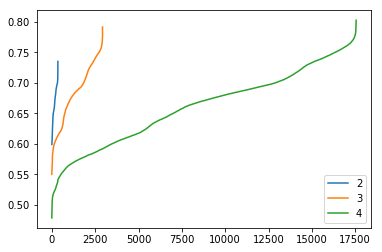

In [63]:
indexes = list(range(len(pcdfs)))
for N in range(2, 5):
    results = []
    for i, iss in tqdm(enumerate(itertools.combinations(indexes, N))):
        ps = []
        fns = []
        for n in range(N):
            ps.append(pcdfs[iss[n]])
            fns.append(motifs_12[iss[n]].filename.stem)
        #print(p1.shape, p2.shape)
        a = np.zeros((NCLUSTERS,)).astype(np.bool)
        a.fill(True)
        for n in range(N):
            a = np.logical_and(a, ~np.isnan(ps[n]))
        a = np.where(a)
        for n in range(N):
            ps[n] = ps[n][a]
        ps = np.array(ps)
        pr = np.product(ps, axis=0)
        assert pr.shape == (len(a[0]),)
        pr = np.sum(pr) / len(a[0]) * N  # Multiplying by N (NOT 2^(N-1) ) normalizes the values wrt to N.
        results.append((pr, fns))
    results.sort(key=lambda trip: trip[0])
    print(results[0])
    X, _ = zip(*results)
    X = list(X)
    plt.plot(list(range(len(X))), X, label=N)
plt.legend()
plt.show()

In [70]:
#keep = ['averaged_sigma1_12', 'averaged_sigma1_21', 'averaged_sigma2_6', 'averaged_sigma2_7']
keep = ['averaged_sigma1_12', 'averaged_sigma1_21', 'averaged_sigma1_22', 'averaged_sigma2_6', 'averaged_sigma2_7']
#keep = ['averaged_sigma0_23', 'averaged_sigma1_6', 'averaged_sigma1_12', 'averaged_sigma1_21', 'averaged_sigma2_6', 'averaged_sigma2_7']
keep = [motif for motif in motifs_12 if motif.filename.stem in keep]
for motif in keep:
    print(motif.filename.stem, motif.vp_index)

averaged_sigma1_12 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma1_21 (0, 3, 6, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma1_22 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_6 (0, 4, 4, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_7 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)


In [71]:
from ppm3d import align, AlignedData
for m1, m2 in itertools.combinations(keep, 2):
    i1 = [i for i, m in enumerate(motifs_12) if m.filename == m1.filename][0]
    i2 = [i for i, m in enumerate(motifs_12) if m.filename == m2.filename][0]
    e1 = motif_errors_12[i1]
    e2 = motif_errors_12[i2]
    a = np.where( (~np.isnan(e1)) & (~np.isnan(e2)) )
    e1, e2 = e1[a], e2[a]
    pr, _ = scipy.stats.pearsonr(e1,e2)
    # TODO: Use a pr cutoff of 0.55. motifs with pr > 0.55 should be considered similar.
    
    data = align(m1.filename, m2.filename)
    data = AlignedData.from_mapping(data)
    print(data.error, m1.filename.stem, m2.filename.stem, pr)

0.06305194765631597 averaged_sigma1_12 averaged_sigma1_21 0.381881742126
0.03758276583650839 averaged_sigma1_12 averaged_sigma1_22 0.462641243634
0.04290794333677046 averaged_sigma1_12 averaged_sigma2_6 0.215108140437
0.051143647117979064 averaged_sigma1_12 averaged_sigma2_7 0.145645167895
0.027679351306618086 averaged_sigma1_21 averaged_sigma1_22 0.533793861862
0.03791249089864034 averaged_sigma1_21 averaged_sigma2_6 0.349722251607
0.03482300295136878 averaged_sigma1_21 averaged_sigma2_7 0.340039387712
0.03402215235246166 averaged_sigma1_22 averaged_sigma2_6 0.396842400586
0.030616740173888383 averaged_sigma1_22 averaged_sigma2_7 0.403417915537
0.03645338727113148 averaged_sigma2_6 averaged_sigma2_7 0.379843745811


In [8]:
def merge_sets(tuple_list):
    iset = set([frozenset(s) for s in tuple_list])  # Convert to a set of sets
    result = []
    while(iset):                  # While there are sets left to process:
        nset = set(iset.pop())      # Pop a new set
        check = len(iset)           # Does iset contain more sets
        while check:                # Until no more sets to check:
            check = False
            for s in iset.copy():       # For each other set:
                if nset.intersection(s):  # if they intersect:
                    check = True            # Must recheck previous sets
                    iset.remove(s)          # Remove it from remaining sets
                    nset.update(s)          # Add it to the current set
        result.append(tuple(nset))  # Convert back to a list of tuples 
    return result


def remove_identical(motifs, CN):
    if False:
        with open(data_path / "norm_factors.json") as f:
            norm_factors = json.load(f)
        print("Loading affinity...")
        L2 = np.load("../data/affinities/L2_affinity.npy")
        L2[np.where(L2 > norm_factors['L2']['set_to_inf_before_dividing'])] = np.inf
        L2 /= norm_factors['L2']['divide_by']
        print("Fitting...")
        L2 = L2[np.where( (~np.isnan(L2)) & (~np.isinf(L2)) )]
        mu, sigma = scipy.stats.norm.fit(L2)
        del L2
        print("Finished")
        np.save('temp.npy', np.array([mu, sigma]))
    mu, sigma = np.load('temp.npy')
    norm = scipy.stats.norm(mu, sigma)

    # Load motif2motif_errors
    motif2motif_errors_path = Path("../data/motif2motif_errors.json")
    if motif2motif_errors_path.exists():
        with open(motif2motif_errors_path) as f:
            motif2motif_errors = json.load(f)
            motif2motif_errors = {tuple(key.split(' + ')): error for key, error in motif2motif_errors.items()}
    else:
        raise OSError("../data/motif2motif_errors.json file does not exist")
    filenames = {m.filename for m in motifs}
    motif2motif_errors = {(f1, f2): v for (f1, f2), v in motif2motif_errors.items() if f1 in filenames and f2 in filenames}
    motif2motif_sims = {key: np.exp(-v) for key, v in motif2motif_errors.items()}


    # Remove identical motifs; I use the motif2motif_errors and the overall gmeans histogram to determine the likelihood of a given pair of motifs having their error (g) value.
    # If the probability is < 1.5% then I consider them identical. I chose 1.5% after looking at some data.
    #for cutoff in np.arange(0, 1, 0.00001):
    cutoff = 0.001
    identical = set()
    for m1, m2 in itertools.combinations(motifs, 2):
        nans = np.logical_or(np.isnan(m1.errors), np.isnan(m2.errors))
        a = np.where(~nans & (cluster_cns == CN))
        pr = scipy.stats.pearsonr(m1.errors[a], m2.errors[a])[0]
        if pr > 0.98:
            aligned = AlignedData.from_mapping(align(m1.filename, m2.filename))
            l2 = aligned.error
            if norm.cdf(l2) < cutoff:
                #print(m1.filename.stem, m2.filename.stem,
                #      l2, norm.cdf(l2), pr,
                #      m1.vp_index[:4], m2.vp_index[:4])
                #a = tuple(sorted([f1, f2]) + [norm.cdf(l2)])
                a = frozenset({m1, m2})
                identical.add(a)
        #print(norm.cdf(l2))
    identical = merge_sets(identical)

    all_in_identical = [m.filename for someset in identical for m in someset]
    keep = [motif.filename for motif in motifs if motif.filename not in all_in_identical]
    # also keep the best one in each set of identicals
    for someset in identical:
        someset = list(someset)
        #print(someset)
        means = []
        for motif in someset:
            #print(motif.filename, motif.vp_index[:4])
            means.append(np.nanmean(motif.errors[np.where(cluster_cns == CN)]))
        k = np.argmin(means)
        keep.append(someset[k])
        #print()
    motifs = [motif for motif in motifs if motif.filename in keep]
    return motifs
    #print(f"After removing identical motifs, {len(motifs)} are left.")
    #print("They are:")
    #for motif in motifs:
    #    print(motif.filename, motif.vp_index[:4])

In [44]:
def load_errors(motifs):
    # Load norm factors
    with open(data_path / "norm_factors.json") as f:
        _norm_factors = json.load(f)
        L2_norm_factors = _norm_factors["L2"]
        L1_norm_factors = _norm_factors["L1"]
        Linf_norm_factors = _norm_factors["Linf"]
        angular_norm_factors = _norm_factors["angular"]
    
    # Load motif errors
    motif_errors = np.zeros((len(motifs), NCLUSTERS, 4))
    motif_errors.fill(np.nan)
    for i, motif in enumerate(motifs):
        fn = Path(motif.filename)
        stem = '_'.join(fn.namebase.split('_')[:])
        efn = motif_errors_path / (stem + '_errors.npy')
        motif_errors[i, :, :] = np.load(efn)

    motif_errors[:, :, 0]
    motif_errors[:, :, 0][np.where(motif_errors[:, :, 0] > L2_norm_factors['set_to_inf_before_dividing'])] = np.inf
    motif_errors[:, :, 0][np.isinf(motif_errors[:, :, 0])] = np.nan
    motif_errors[:, :, 0] /= L2_norm_factors['divide_by']

    motif_errors[:, :, 1]
    motif_errors[:, :, 1][np.where(motif_errors[:, :, 1] > L1_norm_factors['set_to_inf_before_dividing'])] = np.inf
    motif_errors[:, :, 1][np.isinf(motif_errors[:, :, 1])] = np.nan
    motif_errors[:, :, 1] /= L1_norm_factors['divide_by']

    motif_errors[:, :, 2]
    motif_errors[:, :, 2][np.where(motif_errors[:, :, 2] > Linf_norm_factors['set_to_inf_before_dividing'])] = np.inf
    motif_errors[:, :, 2][np.isinf(motif_errors[:, :, 2])] = np.nan
    motif_errors[:, :, 2] /= Linf_norm_factors['divide_by']

    motif_errors[:, :, 3]
    motif_errors[:, :, 3][np.where(motif_errors[:, :, 3] > angular_norm_factors['set_to_inf_before_dividing'])] = np.inf
    motif_errors[:, :, 3][np.isinf(motif_errors[:, :, 3])] = np.nan
    motif_errors[:, :, 3] /= angular_norm_factors['divide_by']

    motif_errors = scipy.stats.gmean(motif_errors, axis=2)
    #print(motif_errors.shape)
    return motif_errors


def find_basis(motifs, motif_errors, cluster_cns):
    """
    `motifs` should be a list of motifs with the SAME coordination number.
    
    `motif_errors` should be a corresponding list of errors for the motifs.
    """
    pcdfs = []
    for i in range(len(motif_errors)):
        errors = motif_errors[i]
        errors = errors[np.where(~np.isnan(errors))]
        cdf = get_cdf(errors)
        X = np.arange(np.amin(errors), np.amax(errors), 0.001)
        Y = cdf(X)

        probs = cdf(motif_errors[i])
        pcdfs.append(probs)
    print(len(pcdfs))
    
    best = []
    
    results = []
    for motif, p in zip(motifs, pcdfs):
        a = np.where( (cluster_cns == motif.CN) & (~np.isnan(p)) )
        p = p[a]
        assert p.shape == (len(a[0]),)
        x = np.mean(p)
        results.append(x)
    idx = np.argmin(results)
    best.append((results[idx], [motifs[idx]]))
    
    indexes = list(range(len(pcdfs)))
    for N in range(2, len(motifs)+1):
        results = []
        for i, iss in tqdm(enumerate(itertools.combinations(indexes, N))):
            ps = []
            _motifs = []
            for n in range(N):
                ps.append(pcdfs[iss[n]])
                _motifs.append(motifs[iss[n]])
            #print(p1.shape, p2.shape)
            #a = np.zeros((NCLUSTERS,)).astype(np.bool)
            #a.fill(True)
            a = (cluster_cns == motifs[iss[n]].CN)
            for n in range(N):
                a = np.logical_and(a, ~np.isnan(ps[n]))
            a = np.where(a)
            for n in range(N):
                ps[n] = ps[n][a]
            ps = np.array(ps)
            x = np.product(ps, axis=0)
            assert x.shape == (len(a[0]),)
            x = np.sum(x) / len(a[0]) * N  # Multiplying by N (NOT 2^(N-1) ) normalizes the values wrt to N.
            results.append((x, _motifs))
        results.sort(key=lambda trip: trip[0])
        best.append(results[0])
        
        
        x, keep = results[0]
        for motif in keep:
            print(motif.filename.stem, motif.vp_index)
        
        xs = []
        for m1, m2 in itertools.combinations(keep, 2):
            i1 = [i for i, m in enumerate(motifs) if m.filename == m1.filename][0]
            i2 = [i for i, m in enumerate(motifs) if m.filename == m2.filename][0]
            e1 = motif_errors[i1]
            e2 = motif_errors[i2]
            a = np.where( (~np.isnan(e1)) & (~np.isnan(e2)) )
            e1, e2 = e1[a], e2[a]
            x, _ = scipy.stats.pearsonr(e1,e2)
            # TODO: Use a x cutoff of 0.55. motifs with x > 0.55 should be considered similar.

            data = align(m1.filename, m2.filename)
            data = AlignedData.from_mapping(data)
            print(data.error, m1.filename.stem, m2.filename.stem, x)
            xs.append(x)
        xs = np.array(xs)
    
        
        X, _ = zip(*results)
        X = list(X)
        plt.plot(X, label=N)
        
        if (xs > 0.80).any():
        #if N == 5:
            plt.legend()
            plt.show()
            return best[-2][1]
        
    plt.legend()
    plt.show()

Identifying basis set for CN 9:
7


1it [00:00, 1190.21it/s]

After removing identical motifs:
2
2
averaged_sigma2_28 (0, 3, 6, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma3_17 (0, 3, 6, 0, 0, 0, 0, 0, 0, 0)
0.012086647611394727 averaged_sigma2_28 averaged_sigma3_17 0.841610096027


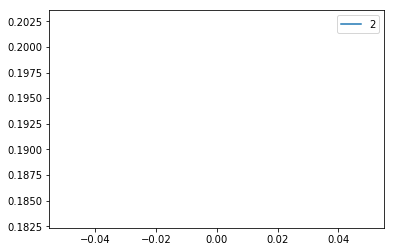

Final results for CN=9
averaged_sigma3_17 (0, 3, 6, 0, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 10:
22


28it [00:00, 4466.27it/s]

After removing identical motifs:
8
8
averaged_sigma1_10 (0, 3, 6, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma3_12 (0, 3, 6, 1, 0, 0, 0, 0, 0, 0)
0.017943031690072594 averaged_sigma1_10 averaged_sigma3_12 0.836661536329


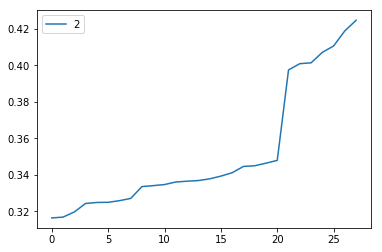

Final results for CN=10
averaged_sigma3_12 (0, 3, 6, 1, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 11:
25


0it [00:00, ?it/s]

After removing identical motifs:
17
17


136it [00:00, 4514.79it/s]
0it [00:00, ?it/s]

averaged_sigma0_10 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_25 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
0.03338400107919403 averaged_sigma0_10 averaged_sigma1_25 0.694467280114


680it [00:00, 3946.49it/s]
359it [00:00, 3583.66it/s]

averaged_sigma0_10 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_0 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_25 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
0.02002778335977425 averaged_sigma0_10 averaged_sigma1_0 0.780216138884
0.03338400107919403 averaged_sigma0_10 averaged_sigma1_25 0.694467280114
0.027043822387780598 averaged_sigma1_0 averaged_sigma1_25 0.691383077326


2380it [00:00, 3543.73it/s]


averaged_sigma0_10 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_0 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_25 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma2_8 (0, 3, 6, 2, 0, 0, 0, 0, 0, 0)
0.02002778335977425 averaged_sigma0_10 averaged_sigma1_0 0.780216138884
0.03338400107919403 averaged_sigma0_10 averaged_sigma1_25 0.694467280114
0.02458859565260654 averaged_sigma0_10 averaged_sigma2_8 0.647898882087
0.027043822387780598 averaged_sigma1_0 averaged_sigma1_25 0.691383077326
0.032337660209058525 averaged_sigma1_0 averaged_sigma2_8 0.524336641232
0.029439060794711296 averaged_sigma1_25 averaged_sigma2_8 0.630120915711


6188it [00:02, 3078.07it/s]


averaged_sigma0_8 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma0_10 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_0 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_25 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma2_8 (0, 3, 6, 2, 0, 0, 0, 0, 0, 0)
0.02061454179863083 averaged_sigma0_8 averaged_sigma0_10 0.763111675566
0.01813031104981743 averaged_sigma0_8 averaged_sigma1_0 0.836749219055
0.016610635502142933 averaged_sigma0_8 averaged_sigma1_25 0.782052211902
0.02904989179913446 averaged_sigma0_8 averaged_sigma2_8 0.595463883188
0.02002778335977425 averaged_sigma0_10 averaged_sigma1_0 0.780216138884
0.03338400107919403 averaged_sigma0_10 averaged_sigma1_25 0.694467280114
0.02458859565260654 averaged_sigma0_10 averaged_sigma2_8 0.647898882087
0.027043822387780598 averaged_sigma1_0 averaged_sigma1_25 0.691383077326
0.032337660209058525 averaged_sigma1_0 averaged_sigma2_8 0.524336641232
0.029439060794711296 averaged_sigma1_25 averaged_sigma2_8 0.630120915711


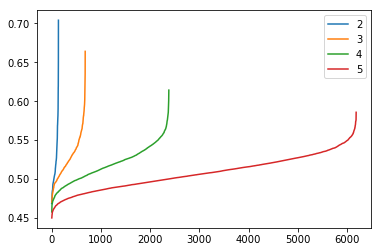

Final results for CN=11
averaged_sigma0_10 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_0 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma1_25 (0, 2, 8, 1, 0, 0, 0, 0, 0, 0)
averaged_sigma2_8 (0, 3, 6, 2, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 12:
27
After removing identical motifs:
23


253it [00:00, 4475.90it/s]

23
averaged_sigma0_2 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma1_26 (0, 3, 6, 3, 0, 0, 0, 0, 0, 0)
0.031872998828685724 averaged_sigma0_2 averaged_sigma1_26 0.550207508299



1771it [00:00, 3879.99it/s]
0it [00:00, ?it/s]

averaged_sigma0_20 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_12 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma1_26 (0, 3, 6, 3, 0, 0, 0, 0, 0, 0)
0.03212413306657355 averaged_sigma0_20 averaged_sigma1_12 0.612719236495
0.027246369231526686 averaged_sigma0_20 averaged_sigma1_26 0.625725319397
0.03613788412777545 averaged_sigma1_12 averaged_sigma1_26 0.493066078992


8855it [00:02, 3427.91it/s]


averaged_sigma0_20 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_23 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_12 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma2_6 (0, 4, 4, 4, 0, 0, 0, 0, 0, 0)
0.026219213308141327 averaged_sigma0_20 averaged_sigma0_23 0.588451013636
0.03212413306657355 averaged_sigma0_20 averaged_sigma1_12 0.612719236495
0.031885005512380764 averaged_sigma0_20 averaged_sigma2_6 0.390363648247
0.03660254302362301 averaged_sigma0_23 averaged_sigma1_12 0.511224130765


321it [00:00, 3202.67it/s]

0.03940533448979507 averaged_sigma0_23 averaged_sigma2_6 0.364441490387
0.04290794333677046 averaged_sigma1_12 averaged_sigma2_6 0.215108140437


33649it [00:10, 3086.60it/s]


averaged_sigma0_15 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma1_12 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma1_21 (0, 3, 6, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_6 (0, 4, 4, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_7 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
0.01609234552308565 averaged_sigma0_15 averaged_sigma1_12 0.882237849359
0.03240037062015563 averaged_sigma0_15 averaged_sigma1_21 0.45847819694
0.03765553599078985 averaged_sigma0_15 averaged_sigma2_6 0.26094902591
0.04300780194323999 averaged_sigma0_15 averaged_sigma2_7 0.179783971659
0.06305194765631597 averaged_sigma1_12 averaged_sigma1_21 0.381881742126
0.04290794333677046 averaged_sigma1_12 averaged_sigma2_6 0.215108140437
0.051143647117979064 averaged_sigma1_12 averaged_sigma2_7 0.145645167895
0.03791249089864034 averaged_sigma1_21 averaged_sigma2_6 0.349722251607
0.03482300295136878 averaged_sigma1_21 averaged_sigma2_7 0.340039387712
0.03645338727113148 averaged_sigma2_6 averaged_sigma2_7 0.379843745811


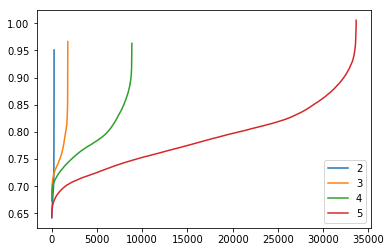

Final results for CN=12
averaged_sigma0_20 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_23 (0, 2, 8, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_12 (0, 0, 12, 0, 0, 0, 0, 0, 0, 0)
averaged_sigma2_6 (0, 4, 4, 4, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 13:
24


66it [00:00, 4443.76it/s]

After removing identical motifs:
12
12
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228



220it [00:00, 3901.76it/s]
0it [00:00, ?it/s]

averaged_sigma1_19 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.033243800504932135 averaged_sigma1_19 averaged_sigma2_3 0.277300206159
0.021623352579729464 averaged_sigma1_19 averaged_sigma3_23 0.644908561845
0.03074652315335696 averaged_sigma2_3 averaged_sigma3_23 0.282195297709


495it [00:00, 3547.72it/s]


averaged_sigma1_19 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.033243800504932135 averaged_sigma1_19 averaged_sigma2_3 0.277300206159
0.03630864114345149 averaged_sigma1_19 averaged_sigma2_17 0.299716106051
0.021623352579729464 averaged_sigma1_19 averaged_sigma3_23 0.644908561845


0it [00:00, ?it/s]

0.0416545984961618 averaged_sigma2_3 averaged_sigma2_17 0.274175528439
0.03074652315335696 averaged_sigma2_3 averaged_sigma3_23 0.282195297709
0.036244391585978364 averaged_sigma2_17 averaged_sigma3_23 0.249612794738


792it [00:00, 3229.21it/s]


averaged_sigma1_19 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.033243800504932135 averaged_sigma1_19 averaged_sigma2_3 0.277300206159
0.03630864114345149 averaged_sigma1_19 averaged_sigma2_17 0.299716106051
0.01961255317804726 averaged_sigma1_19 averaged_sigma3_20 0.617889293797
0.021623352579729464 averaged_sigma1_19 averaged_sigma3_23 0.644908561845
0.0416545984961618 averaged_sigma2_3 averaged_sigma2_17 0.274175528439
0.031181485106776964 averaged_sigma2_3 averaged_sigma3_20 0.37517143899
0.03074652315335696 averaged_sigma2_3 averaged_sigma3_23 0.282195297709


0it [00:00, ?it/s]

0.031440596077641235 averaged_sigma2_17 averaged_sigma3_20 0.346277687221
0.036244391585978364 averaged_sigma2_17 averaged_sigma3_23 0.249612794738
0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228


924it [00:00, 2946.37it/s]


averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_19 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.019776117033628797 averaged_sigma0_18 averaged_sigma1_19 0.686791845737
0.029577170505065118 averaged_sigma0_18 averaged_sigma2_3 0.32625098259
0.038132305347054786 averaged_sigma0_18 averaged_sigma2_17 0.286412225907
0.024841612309319548 averaged_sigma0_18 averaged_sigma3_20 0.555350718022
0.02279506374126192 averaged_sigma0_18 averaged_sigma3_23 0.641535475754
0.033243800504932135 averaged_sigma1_19 averaged_sigma2_3 0.277300206159
0.03630864114345149 averaged_sigma1_19 averaged_sigma2_17 0.299716106051
0.01961255317804726 averaged_sigma1_19 averaged_sigma3_20 0.617889293797
0.021623352579729464 averaged_sigma1_19 averaged_sigma3_23 0.644908561845
0.0416545984961618 averaged_sigma2_3 

0it [00:00, ?it/s]

0.03074652315335696 averaged_sigma2_3 averaged_sigma3_23 0.282195297709
0.031440596077641235 averaged_sigma2_17 averaged_sigma3_20 0.346277687221
0.036244391585978364 averaged_sigma2_17 averaged_sigma3_23 0.249612794738
0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228


792it [00:00, 2728.12it/s]


averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_21 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_29 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.020983383160148427 averaged_sigma0_18 averaged_sigma0_21 0.684043641526
0.029577170505065118 averaged_sigma0_18 averaged_sigma2_3 0.32625098259
0.038132305347054786 averaged_sigma0_18 averaged_sigma2_17 0.286412225907
0.019262605265814286 averaged_sigma0_18 averaged_sigma2_29 0.680469403577
0.024841612309319548 averaged_sigma0_18 averaged_sigma3_20 0.555350718022
0.02279506374126192 averaged_sigma0_18 averaged_sigma3_23 0.641535475754
0.03800884909206471 averaged_sigma0_21 averaged_sigma2_3 0.274800181627
0.03584493805631619 averaged_sigma0_21 averaged_sigma2_17 0.296663675839
0.02101239399846893 averaged_sigma0_21 averaged_sigma2_29 0.

258it [00:00, 2572.45it/s]

0.02201957147376653 averaged_sigma2_29 averaged_sigma3_23 0.620833760949
0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228


495it [00:00, 2546.19it/s]


averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_21 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_4 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_29 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.020983383160148427 averaged_sigma0_18 averaged_sigma0_21 0.684043641526
0.029577170505065118 averaged_sigma0_18 averaged_sigma2_3 0.32625098259
0.015404679294412459 averaged_sigma0_18 averaged_sigma2_4 0.727421853412
0.038132305347054786 averaged_sigma0_18 averaged_sigma2_17 0.286412225907
0.019262605265814286 averaged_sigma0_18 averaged_sigma2_29 0.680469403577
0.024841612309319548 averaged_sigma0_18 averaged_sigma3_20 0.555350718022
0.02279506374126192 averaged_sigma0_18 averaged_sigma3_23 0.641535475754
0.03800884909206471 averaged_sigma0_21 averaged_sigma2_3 0.274800181627
0.02097004

220it [00:00, 2391.24it/s]

0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228
averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_21 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_4 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_13 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_29 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.020983383160148427 averaged_sigma0_18 averaged_sigma0_21 0.684043641526


0.029577170505065118 averaged_sigma0_18 averaged_sigma2_3 0.32625098259
0.015404679294412459 averaged_sigma0_18 averaged_sigma2_4 0.727421853412
0.023378934874859723 averaged_sigma0_18 averaged_sigma2_13 0.642919558885
0.038132305347054786 averaged_sigma0_18 averaged_sigma2_17 0.286412225907
0.019262605265814286 averaged_sigma0_18 averaged_sigma2_29 0.680469403577
0.024841612309319548 averaged_sigma0_18 averaged_sigma3_20 0.555350718022
0.02279506374126192 averaged_sigma0_18 averaged_sigma3_23 0.641535475754
0.03800884909206471 averaged_sigma0_21 averaged_sigma2_3 0.274800181627
0.020970045809480958 averaged_sigma0_21 averaged_sigma2_4 0.67606450269
0.01824377855437611 averaged_sigma0_21 averaged_sigma2_13 0.675878786484
0.03584493805631619 averaged_sigma0_21 averaged_sigma2_17 0.296663675839
0.02101239399846893 averaged_sigma0_21 averaged_sigma2_29 0.644742962063
0.027549458099013574 averaged_sigma0_21 averaged_sigma3_20 0.573243023348
0.01926710998727877 averaged_sigma0_21 averaged_s

0it [00:00, ?it/s]

0.036244391585978364 averaged_sigma2_17 averaged_sigma3_23 0.249612794738
0.019903374814897314 averaged_sigma2_29 averaged_sigma3_20 0.616982472114
0.02201957147376653 averaged_sigma2_29 averaged_sigma3_23 0.620833760949
0.024150893958825057 averaged_sigma3_20 averaged_sigma3_23 0.531402215228


66it [00:00, 2094.03it/s]


averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_21 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_19 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_4 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_13 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_29 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
0.020983383160148427 averaged_sigma0_18 averaged_sigma0_21 0.684043641526
0.019776117033628797 averaged_sigma0_18 averaged_sigma1_19 0.686791845737
0.029577170505065118 averaged_sigma0_18 averaged_sigma2_3 0.32625098259
0.015404679294412459 averaged_sigma0_18 averaged_sigma2_4 0.727421853412
0.023378934874859723 averaged_sigma0_18 averaged_sigma2_13 0.642919558885
0.038132305347054786 averaged_sigma0_18 averaged_sigma2_17 0.286412225907
0.019262605265814286 averaged_sigma0_18 averaged_sigm

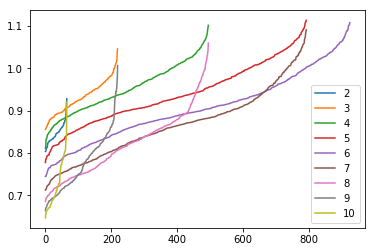

Final results for CN=13
averaged_sigma0_18 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma0_21 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_3 (0, 2, 8, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_4 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_13 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma2_17 (0, 3, 6, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_29 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_20 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_23 (0, 1, 10, 2, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 14:
13


21it [00:00, 4433.28it/s]

After removing identical motifs:
7
7
averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_31 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
0.025034477194727314 averaged_sigma2_1 averaged_sigma2_31 0.650674662187



35it [00:00, 3915.31it/s]


averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_31 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_0 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0)
0.025034477194727314 averaged_sigma2_1 averaged_sigma2_31 0.650674662187
0.025835403756017096 averaged_sigma2_1 averaged_sigma3_0 0.509821882458


35it [00:00, 2403.14it/s]

0.03278181655966516 averaged_sigma2_31 averaged_sigma3_0 0.448815452132
averaged_sigma1_13 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_20 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma3_0 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0)
0.027087242900943165 averaged_sigma1_13 averaged_sigma1_20 0.550071164117


0.02230869541486733 averaged_sigma1_13 averaged_sigma2_1 0.668544978344
0.025052070810213 averaged_sigma1_13 averaged_sigma3_0 0.548424890238
0.021247046443087905 

0it [00:00, ?it/s]

averaged_sigma1_20 averaged_sigma2_1 0.684950699116
0.031196915214958557 averaged_sigma1_20 averaged_sigma3_0 0.474403283175
0.025835403756017096 averaged_sigma2_1 averaged_sigma3_0 0.509821882458


21it [00:00, 2230.11it/s]


averaged_sigma1_13 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_20 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_31 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_0 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0)
0.027087242900943165 averaged_sigma1_13 averaged_sigma1_20 0.550071164117
0.02230869541486733 averaged_sigma1_13 averaged_sigma2_1 0.668544978344
0.02024822958728601 averaged_sigma1_13 averaged_sigma2_31 0.653505880256
0.025052070810213 averaged_sigma1_13 averaged_sigma3_0 0.548424890238
0.021247046443087905 averaged_sigma1_20 averaged_sigma2_1 0.684950699116
0.019615195610135354 averaged_sigma1_20 averaged_sigma2_31 0.661391695655
0.031196915214958557 averaged_sigma1_20 averaged_sigma3_0 0.474403283175
0.025034477194727314 averaged_sigma2_1 averaged_sigma2_31 0.650674662187


7it [00:00, 2630.13it/s]

0.025835403756017096 averaged_sigma2_1 averaged_sigma3_0 0.509821882458
0.03278181655966516 averaged_sigma2_31 averaged_sigma3_0 0.448815452132
averaged_sigma1_13 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_20 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_31 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_0 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma3_15 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
0.027087242900943165 averaged_sigma1_13 averaged_sigma1_20 0.550071164117


0.02230869541486733 averaged_sigma1_13 averaged_sigma2_1 0.668544978344
0.02024822958728601 averaged_sigma1_13 averaged_sigma2_31 0.653505880256
0.025052070810213 averaged_sigma1_13 averaged_sigma3_0 0.548424890238
0.019486736273175116 averaged_sigma1_13 averaged_sigma3_15 0.727567769168
0.021247046443087905 averaged_sigma1_20 averaged_sigma2_1 0.684950699116
0.019615195610135354 averaged_sigma1_20 averaged_sigma2_31 0.661391695655
0.031196915214958557 averaged_sigma1_20 averaged_sigma3_0 0.474403283175
0.02406048619755219 averaged_sigma1_20 averaged_sigma3_15 0.626855104191
0.025034477194727314 averaged_sigma2_1 averaged_sigma2_31 0.650674662187
0.025835403756017096 averaged_sigma2_1 averaged_sigma3_0 0.509821882458
0.007211493317302391 averaged_sigma2_1 averaged_sigma3_15 0.871351649953
0.03278181655966516 averaged_sigma2_31 averaged_sigma3_0 0.448815452132
0.023634024666944742 averaged_sigma2_31 averaged_sigma3_15 0.624266576233
0.026178732483643094 averaged_sigma3_0 averaged_sigma3

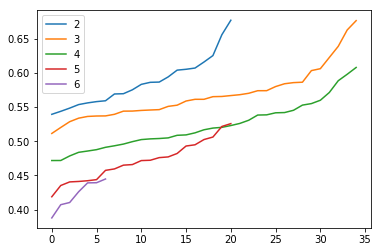

Final results for CN=14
averaged_sigma1_13 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma1_20 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_1 (0, 1, 10, 3, 0, 0, 0, 0, 0, 0)
averaged_sigma2_31 (0, 0, 12, 2, 0, 0, 0, 0, 0, 0)
averaged_sigma3_0 (0, 2, 8, 4, 0, 0, 0, 0, 0, 0)

Identifying basis set for CN 15:
10


28it [00:00, 5455.24it/s]

After removing identical motifs:
8
8
averaged_sigma0_25 (0, 1, 10, 4, 0, 0, 0, 0, 0, 0)
averaged_sigma2_26 (0, 1, 10, 4, 0, 0, 0, 0, 0, 0)
0.009904940000607439 averaged_sigma0_25 averaged_sigma2_26 0.897397512297


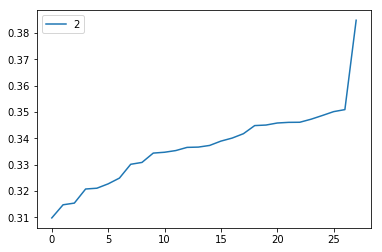

Final results for CN=15
averaged_sigma0_25 (0, 1, 10, 4, 0, 0, 0, 0, 0, 0)



In [47]:
CN = 9
cnmin = np.amin([motif.CN for motif in motifs])
cnmax = np.amax([motif.CN for motif in motifs])
for CN in range(cnmin, cnmax+1):
    print(f"Identifying basis set for CN {CN}:")
    motifs_cn = [motif for motif in motifs if motif.CN == CN]
    print(len(motifs_cn))

    # Remove identical
    motif_cn_errors = load_errors(motifs_cn)
    for m, e in zip(motifs_cn, motif_cn_errors):
        m.errors = e
    motifs_cn = remove_identical(motifs_cn, CN=CN)
    motif_cn_errors = load_errors(motifs_cn)
    print("After removing identical motifs:")
    print(len(motifs_cn))
    #print(len(motif_cn_errors))

    motif_cn_errors = load_errors(motifs_cn)
    basis = find_basis(motifs_cn, motif_cn_errors, cluster_cns)

    print(f"Final results for CN={CN}")
    for motif in basis:
        print(motif.filename.stem, motif.vp_index)
    print()

In [46]:
!pwd

/home/jjmaldonis/backup/alignment_work/Zr50Cu45Al5_md_alignment/20180417_ppm3d_correct_rerun/600K/ppm3d_correct/analysis/motif_analysis
